# Simple Example

A simple end-to-end example. 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DEVICE = "cpu"

## Dataset Definition
Generates piece-wise linear data.

In [3]:
class MyDataset(torch.utils.data.IterableDataset):
    def __iter__(self):
        return self
    def __next__(self):
        X_orig = np.random.randint(0, 100) % 100
        X = (X_orig - 50.0) / (100/np.sqrt(12))
        if X_orig < 50:
            y = X * np.random.randint(1, 3) + np.random.uniform(0, 2)
        else:
            y = np.random.uniform(0, 2)
        return np.array([X], dtype=np.float32), np.array([y], dtype=np.float32)

## Module Definition

In [4]:
class TwoLayerModel(torch.nn.Module):
    def  __init__(self, D_IN, D_OUT, H):
        super(TwoLayerModel, self).__init__()
        self._l1 = torch.nn.Linear(D_IN, H)
        self._l2 = torch.nn.Linear(H, H)
        self._l3 = torch.nn.Linear(H, D_OUT)

    def forward(self, x):
        x = torch.nn.functional.relu(self._l1(x))
        x = torch.nn.functional.relu(self._l2(x))
        x = self._l3(x)
        return x

## Build Dataset and Model

In [5]:
train_dataset = MyDataset()
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 8,
)
iter_train_dataloader = iter(train_dataloader)

model = TwoLayerModel(
    D_IN = 1,
    D_OUT = 1,
    H = 4,
)

## Train Setup

In [6]:
loss_fn = torch.nn.MSELoss(reduction="mean")
optim = torch.optim.Adam(model.parameters())

## Training Loop

In [7]:
model.to(DEVICE)
for i in range(10_000):
    optim.zero_grad()
    X, y = next(iter_train_dataloader)
    X, y = X.to(DEVICE), y.to(DEVICE)
    output = model(X)
    loss = loss_fn(output, y)
    if (i+1) % 1_000 == 0:
        print(f"loss @ {i+1}th step: {loss}")
    loss.backward()
    optim.step()

loss @ 1000th step: 0.6373478770256042
loss @ 2000th step: 0.3785862624645233
loss @ 3000th step: 0.5245296955108643
loss @ 4000th step: 0.5547906756401062
loss @ 5000th step: 0.36957424879074097
loss @ 6000th step: 0.47447144985198975
loss @ 7000th step: 0.7026658654212952
loss @ 8000th step: 0.8914526700973511
loss @ 9000th step: 0.2070406973361969
loss @ 10000th step: 0.31564435362815857


## Test Results

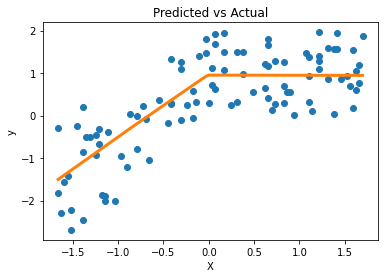

In [9]:
model.to("cpu")

X, y, y_pred = [], [], []
iter_dataset = iter(train_dataset)
for _ in range(100):
    _X, _y = next(iter_dataset)
    X.append(_X)
    y.append(_y)
    with torch.no_grad():
        y_pred.append(model(torch.Tensor(_X)))

# sort results for visualizing
X, y, y_pred = zip(*sorted(zip(X, y, y_pred)))

# plot!
fig, ax = plt.subplots(1, 1)
ax.set_title("Predicted vs Actual")
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.scatter(np.stack(X), np.stack(y), color="tab:blue")
ax.plot(np.stack(X), np.stack(y_pred), linewidth=3, color="tab:orange")
plt.show()